# Holography Simulator

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.restoration import unwrap_phase, richardson_lucy

from libertem.utils.generate import hologram_frame
from libertem.io.dataset.memory import MemoryDataSet
from libertem.udf.holography import HoloReconstructUDF
from libertem.api import Context

import hyperspy.api as hs
from holospy.reconstruct import (
    estimate_sideband_position,
    estimate_sideband_size,
    reconstruct,
    freq_array,
)
from scipy.signal import convolve2d, convolve
from scipy.fft import fft2, ifft2, fftfreq
from scipy.optimize import minimize

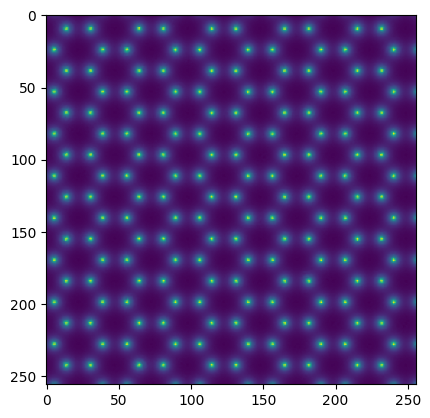

In [57]:
# # Define grid
# sx, sy = (256, 256)
# mx, my = np.meshgrid(np.arange(sx), np.arange(sy))
# # Define sphere region
# sphere = (mx - 33.)**2 + (my - 103.)**2 < 20.**2
# # Calculate long-range contribution to the phase
# phase = ((mx - 33.)**2 + (my - 103.)**2) / sx / 40.
# # Add mean inner potential contribution to the phase
# phase[sphere] += (-((mx[sphere] - 33.)**2 \
#                    + (my[sphere] - 103.)**2) / sx / 3 + 0.5) * 2.
# # Calculate amplitude of the phase
# amp = np.ones_like(phase)
# amp[sphere] = ((mx[sphere] - 33.)**2 \
#                + (my[sphere] - 103.)**2) / sx / 3 + 0.5

# Load the phase an amplitude images
phase = np.load('dense_graphene_phase.npy')
amp = np.load('dense_graphene_amp.npy')

# Crop the images
phase = phase[20:276, 20:276]
amp = amp[20:276, 20:276]

plt.imshow(phase)

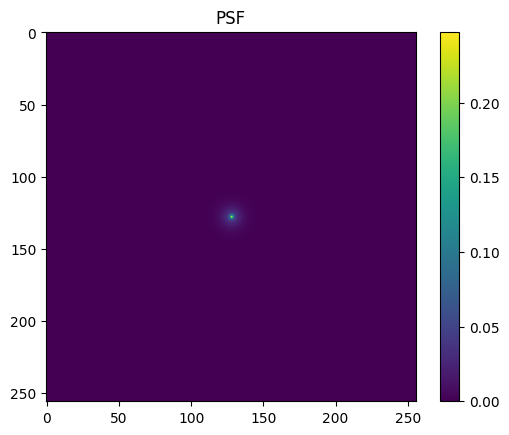

In [28]:
full_psf = np.load('UltraScan1000FT.npz')['arr_0']
# full_psf = np.load('k3.npz')['psf']
plt.figure()
plt.title('PSF')
plt.imshow(full_psf)
plt.colorbar()
plt.show()

In [4]:
# # Apply the PSF to the amplitude
# amp_filtered = convolve2d(amp, full_psf, mode='same', boundary='symm')
# # Apply the PSF to phase
# phase_filtered = convolve2d(phase, full_psf, mode='same', boundary='symm')

In [34]:
img = convolve2d(amp * np.exp(1j * phase), full_psf, mode='same', boundary='symm')
amp_filtered = np.abs(img)
phase_filtered = np.angle(img)

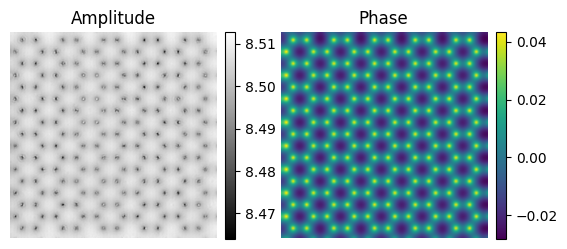

In [35]:
# Plot
f, axs = plt.subplots(1, 2)
im1 = axs[0].imshow(amp_filtered, cmap='gray')
axs[0].title.set_text('Amplitude')
axs[0].set_axis_off()
cbar1 = f.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
im2 = axs[1].imshow(phase_filtered, cmap='viridis')
axs[1].title.set_text('Phase')
axs[1].set_axis_off()
cbar2 = f.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
plt.show()

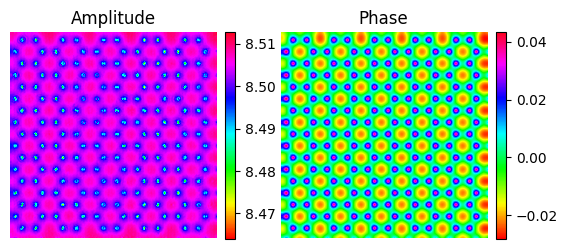

In [58]:
phase_unwrapped = unwrap_phase(phase_filtered)
# Plot
f, axs = plt.subplots(1, 2)
im1 = axs[0].imshow(amp_filtered, cmap='hsv')
axs[0].title.set_text('Amplitude')
axs[0].set_axis_off()
cbar1 = f.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
im2 = axs[1].imshow(phase_unwrapped, cmap='hsv')
axs[1].title.set_text('Phase')
axs[1].set_axis_off()
cbar2 = f.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
plt.show()

In [59]:
amp = amp_filtered
phase = phase_unwrapped

Compute holograms

In [38]:
## Noiseless hologram
counts = 1000
sampling = 5

holo_perfect = hologram_frame(amp, phase, counts=counts, sampling=sampling)
ref_perfect = hologram_frame(np.ones_like(phase), np.zeros_like(phase), counts=counts, sampling=sampling)


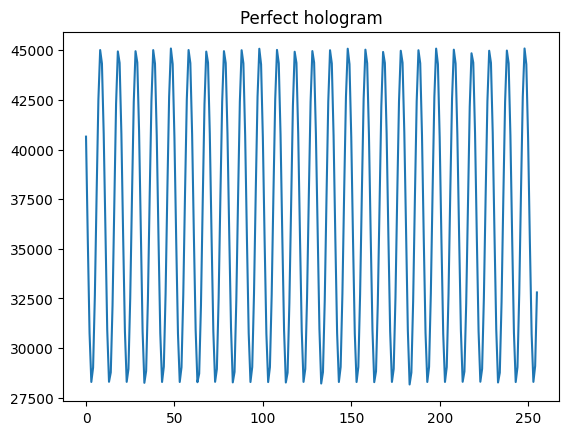

In [39]:
plt.figure()
plt.title('Perfect hologram')
plt.plot(holo_perfect[holo_perfect.shape[0]//2])
plt.show()

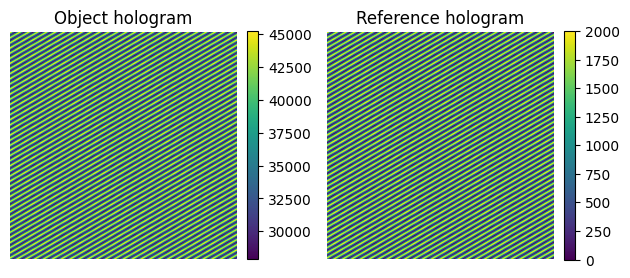

In [ ]:
## Noiseless hologram
counts = 1000
poisson_noise = 0.1
sampling = 5

holo = hologram_frame(amp, phase, counts=counts, poisson_noise=poisson_noise, sampling=sampling)
ref = hologram_frame(np.ones_like(phase), np.zeros_like(phase), counts=counts, poisson_noise=poisson_noise, sampling=sampling)

# Plot
cmap = 'viridis'
f, axs = plt.subplots(1, 2)
im1 = axs[0].imshow(holo, cmap=cmap)
axs[0].title.set_text('Object hologram')
axs[0].set_axis_off()
cbar1 = f.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)

im2 = axs[1].imshow(ref, cmap=cmap)
axs[1].title.set_text('Reference hologram')
axs[1].set_axis_off()
cbar2 = f.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

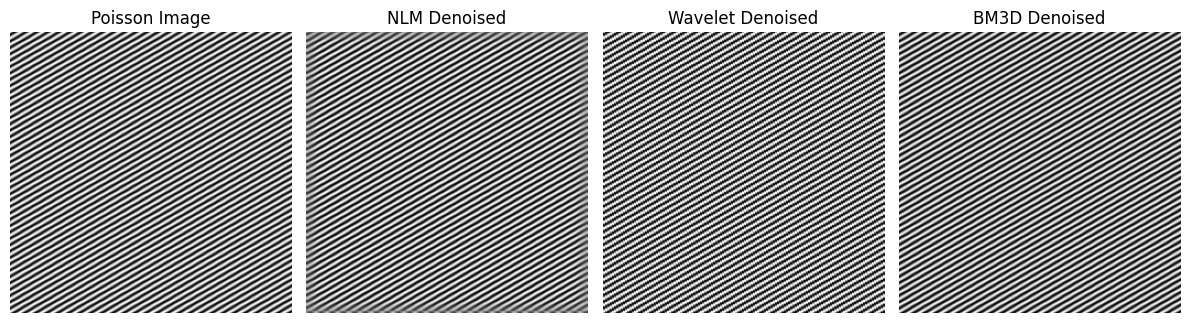

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import restoration
from skimage.restoration import denoise_wavelet
from bm3d import bm3d, BM3DProfile

# Functions for Anscombe Transform and its Inverse
def anscombe_transform(image):
    """Apply the Anscombe transform to stabilize Poisson noise."""
    return 2 * np.sqrt(image + 3 / 8)

def inverse_anscombe(image, unbiased=True):
    """Apply the inverse Anscombe transform."""
    if unbiased:
        return (image / 2) ** 2 - 1 / 8 + 1/4 * np.sqrt(3/2) * 1.0/image - 11/8 * 1.0/image**2 + 5/8 * np.sqrt(3/2) /image**3 
    else:
        return (image / 2) ** 2 - 3 / 8


original_image = holo

# Apply the Anscombe transform
transformed_image = anscombe_transform(original_image)

nlm_denoised = restoration.denoise_nl_means(
    transformed_image,
    patch_size=7,
    patch_distance=11,
    h=1.15 * np.std(transformed_image),
    fast_mode=True
)

# Apply the inverse Anscombe transform
nlm_result = inverse_anscombe(nlm_denoised)

## 2. Wavelet Denoising
wavelet_denoised = denoise_wavelet(
    transformed_image,
    method='BayesShrink',
    mode='soft',
    wavelet_levels=1,
    rescale_sigma=True
)

wavelet_result = inverse_anscombe(wavelet_denoised)

## 3. BM3D
bm3d_denoised = bm3d(transformed_image, sigma_psd=np.std(transformed_image))
bm3d_result = inverse_anscombe(bm3d_denoised)


# Plot the results
plt.figure(figsize=(12, 8))
titles = ["Poisson Image", "NLM Denoised", "Wavelet Denoised", "BM3D Denoised"]
images = [original_image, nlm_result, wavelet_result, bm3d_result]

for i, (title, img) in enumerate(zip(titles, images), 1):
    plt.subplot(1, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

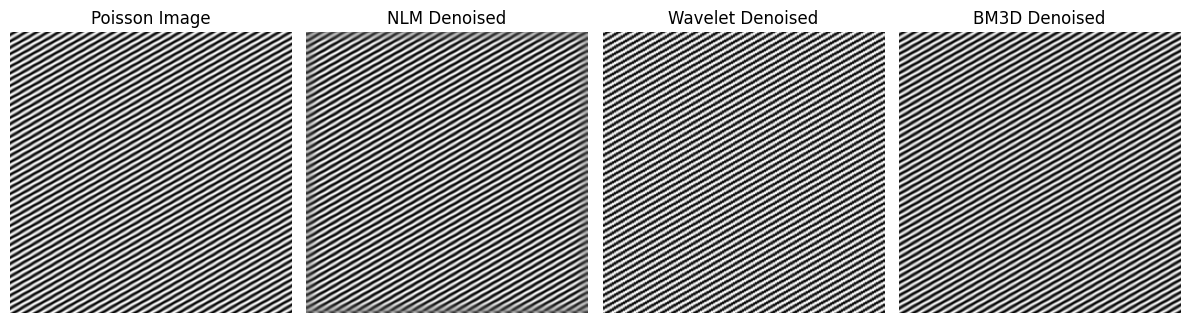

In [62]:
original_ref = ref

# Apply the Anscombe transform
transformed_image = anscombe_transform(original_ref)

nlm_denoised = restoration.denoise_nl_means(
    transformed_image,
    patch_size=7,
    patch_distance=11,
    h=1.15 * np.std(transformed_image),
    fast_mode=True
)

# Apply the inverse Anscombe transform
nlm_ref = inverse_anscombe(nlm_denoised)

## 2. Wavelet Denoising
wavelet_denoised = denoise_wavelet(
    transformed_image,
    method='BayesShrink',
    mode='soft',
    wavelet_levels=1,
    rescale_sigma=True
)

wavelet_ref = inverse_anscombe(wavelet_denoised)

## 3. BM3D
bm3d_denoised = bm3d(transformed_image, sigma_psd=np.std(transformed_image))
bm3d_ref = inverse_anscombe(bm3d_denoised)


# Plot the results
plt.figure(figsize=(12, 8))
titles = ["Poisson Image", "NLM Denoised", "Wavelet Denoised", "BM3D Denoised"]
images = [original_ref, nlm_ref, wavelet_ref, bm3d_ref]

for i, (title, img) in enumerate(zip(titles, images), 1):
    plt.subplot(1, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

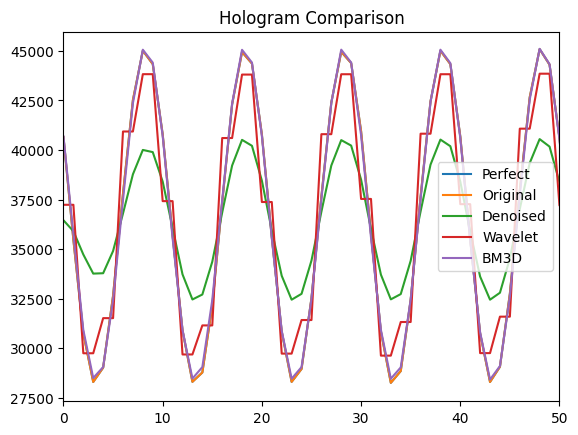

In [63]:
plt.figure()
plt.title('Hologram Comparison')
plt.plot(holo_perfect[holo_perfect.shape[0]//2], label='Perfect')
plt.plot(original_image[original_image.shape[0]//2], label='Original')
plt.plot(nlm_result[original_image.shape[0]//2], label='Denoised')
plt.plot(wavelet_result[original_image.shape[0]//2], label='Wavelet')
plt.plot(bm3d_result[original_image.shape[0]//2], label='BM3D')
plt.xlim(0,50)
plt.legend()
plt.show()

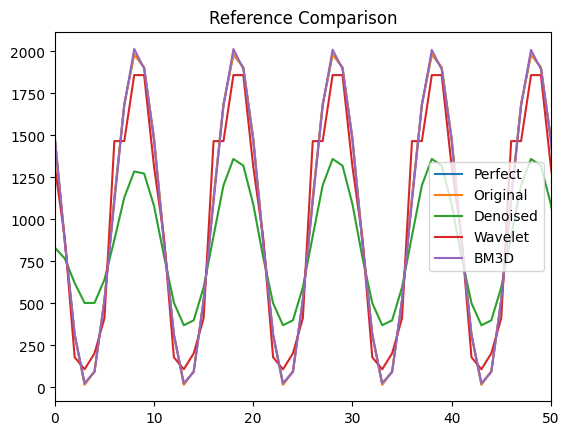

In [64]:
plt.figure()
plt.title('Reference Comparison')
plt.plot(ref_perfect[ref_perfect.shape[0]//2], label='Perfect')
plt.plot(original_ref[original_ref.shape[0]//2], label='Original')
plt.plot(nlm_ref[original_ref.shape[0]//2], label='Denoised')
plt.plot(wavelet_ref[original_ref.shape[0]//2], label='Wavelet')
plt.plot(bm3d_ref[original_ref.shape[0]//2], label='BM3D')
plt.xlim(0,50)
plt.legend()
plt.show()

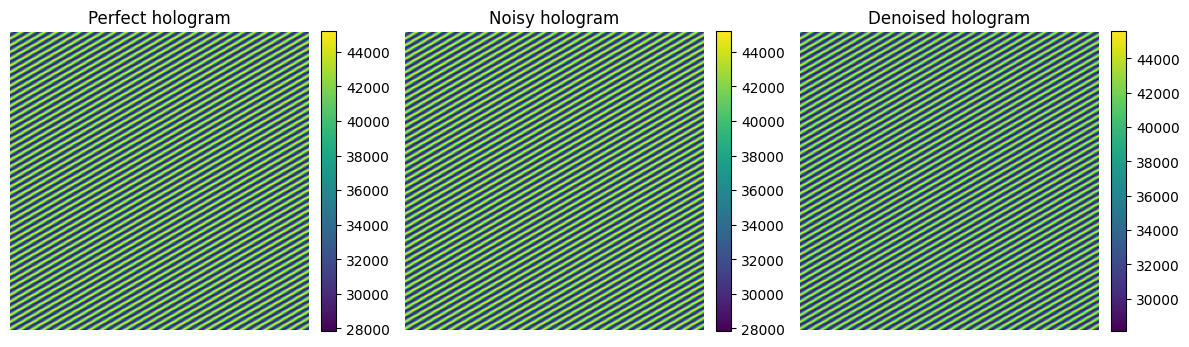

In [65]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
im1 = axs[0].imshow(holo_perfect)
axs[0].title.set_text('Perfect hologram')
axs[0].set_axis_off()
cbar1 = fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)

im2 = axs[1].imshow(holo)
axs[1].title.set_text('Noisy hologram')
axs[1].set_axis_off()
cbar2 = fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

im3 = axs[2].imshow(bm3d_result)
axs[2].title.set_text('Denoised hologram')
axs[2].set_axis_off()
cbar3 = fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

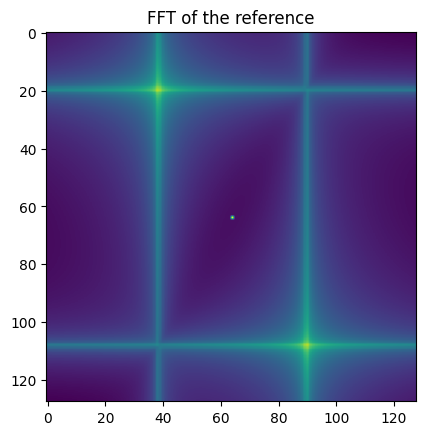

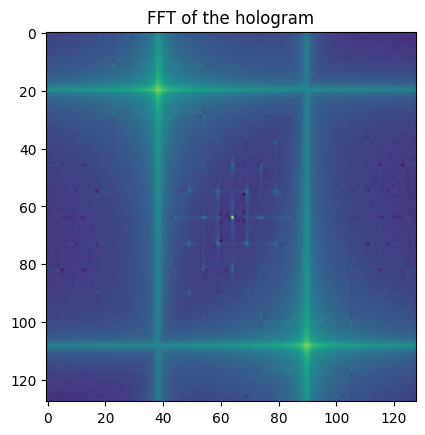

In [66]:
plt.figure()
fft_ref = np.log(np.abs(np.fft.fftshift(np.fft.fft2(ref))))
plt.imshow(fft_ref[fft_ref.shape[0]//4:3*fft_ref.shape[0]//4, fft_ref.shape[1]//4:3*fft_ref.shape[1]//4])
plt.title('FFT of the reference')
plt.show()

plt.figure()
fft_holo = np.log(np.abs(np.fft.fftshift(np.fft.fft2(holo))))
plt.imshow(fft_holo[fft_holo.shape[0]//4:3*fft_holo.shape[0]//4, fft_holo.shape[1]//4:3*fft_holo.shape[1]//4])
plt.title('FFT of the hologram')
plt.show()

In [67]:
holo = original_image

(sx, sy) = (256, 256)

dataset_holo = MemoryDataSet(data=holo.reshape((1, sx, sy)), tileshape=(1, sx, sy), num_partitions=1, sig_dims=2)
dataset_ref = MemoryDataSet(data=ref.reshape((1, sx, sy)), tileshape=(1, sx, sy), num_partitions=1, sig_dims=2)



# Store the hologram in a Singal2D to estimate the sideband position and size
holo_signal2d = hs.signals.Signal2D(ref)
holo_signal2d.set_signal_type("hologram")

sb_position = holo_signal2d.estimate_sideband_position(ap_cb_radius=None, sb='upper')
sb_size = holo_signal2d.estimate_sideband_size(sb_position)

sb_position = sb_position.data
sb_size = sb_size.data[0]

print(f'Sideband position: {sb_position}')
print(f'Sideband size: {sb_size}')

Sideband position: [212 230]
Sideband size: 25.553864678361276


In [71]:
def run_reconstruct(holo, ref):
    # Setup context
    ctx = Context()

    dataset_holo = MemoryDataSet(data=holo.reshape((1, sx, sy)), tileshape=(1, sx, sy), num_partitions=1, sig_dims=2)
    dataset_ref = MemoryDataSet(data=ref.reshape((1, sx, sy)), tileshape=(1, sx, sy), num_partitions=1, sig_dims=2)

    # Store the hologram in a Singal2D to estimate the sideband position and size
    holo_signal2d = hs.signals.Signal2D(ref)
    holo_signal2d.set_signal_type("hologram")

    sb_position = holo_signal2d.estimate_sideband_position(ap_cb_radius=None, sb='lower')
    sb_size = holo_signal2d.estimate_sideband_size(sb_position)

    sb_position = sb_position.data
    sb_size = sb_size.data[0]

    # Define output shape
    output_shape = (int(sb_size * 2), int(sb_size * 2))

    # Create reconstruction UDF:
    holo_udf = HoloReconstructUDF(out_shape=output_shape,
                                sb_position=sb_position,
                                sb_size=sb_size)

    # Reconstruct holograms, access data directly
    w_holo = ctx.run_udf(dataset=dataset_holo, udf=holo_udf)['wave'].data
    w_ref = ctx.run_udf(dataset=dataset_ref, udf=holo_udf)['wave'].data
    # Correct object wave using reference wave
    w = w_holo / w_ref

    # Calculate plot phase shift and amplitude
    amp_r = np.abs(w)
    phase_r = np.angle(w)
    # Unwrap phase:
    phase_unwrapped = unwrap_phase(phase_r[0])

    ctx.close()

    # Plot amplitude
    f, ax = plt.subplots(1, 2)
    ax[0].imshow(amp)
    ax[0].title.set_text('Input amplitude')
    ax[1].imshow(amp_r[0])
    ax[1].title.set_text('Reconstructed amplitude')
    plt.show()

    # Plot
    f, axs = plt.subplots(1, 3, figsize=(9, 3))
    im1 = axs[0].imshow(phase, cmap = 'twilight')
    axs[0].title.set_text('Input phase')
    axs[0].set_axis_off()
    cbar1 = f.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)

    im2 = axs[1].imshow(phase_r[0], cmap = 'twilight')
    axs[1].title.set_text('Reconstructed phase')
    axs[1].set_axis_off()
    cbar2 = f.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

    im3 = axs[2].imshow(phase_unwrapped, cmap='twilight')
    axs[2].title.set_text('Reconstructed phase (unwrapped)')
    axs[2].set_axis_off()
    cbar3 = f.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

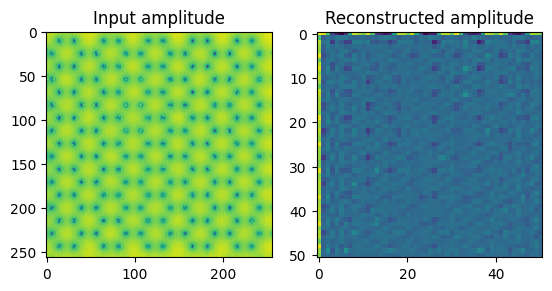

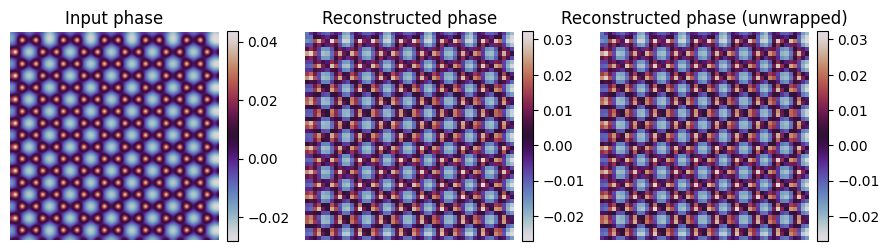

In [72]:
run_reconstruct(original_image, original_ref)

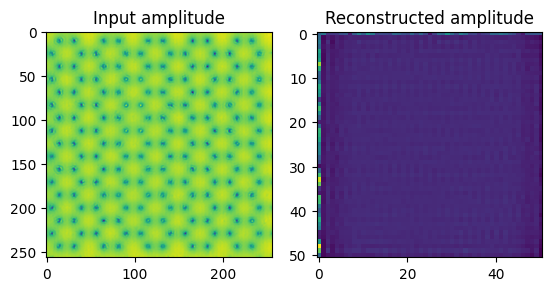

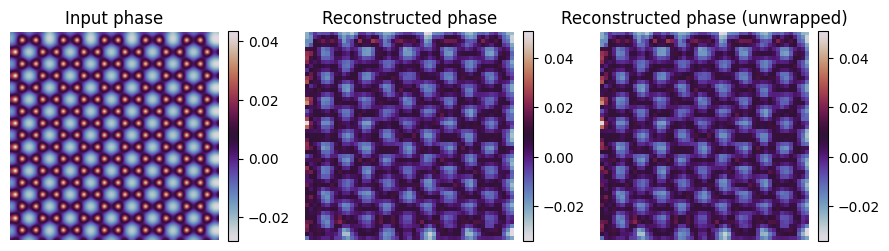

In [73]:
run_reconstruct(bm3d_result, bm3d_ref)